# Multimodal Gesture Recognition: From EDA to Production Models

**Project:** Kaggle CMI - Detect Behavior with Sensor Data  
**Author:** Nadav Sadna Project  
**Date:** January 2026  

---

## Executive Summary

This notebook presents a complete analysis of wearable sensor data for gesture recognition, focusing on distinguishing Body-Focused Repetitive Behaviors (BFRB) from everyday gestures. The project addresses a challenging real-world constraint: **50% of test data will only have IMU sensors available**, while the other 50% will have full sensor suite (IMU + Time-of-Flight + Thermal).

**Key Achievements:**
- Built dual XGBoost models achieving **0.7351 overall competition score**
- Engineered 158 features from multimodal sensor data
- Validated that ToF and thermal sensors provide **+14.2% improvement** over IMU-only
- Identified critical features for gesture discrimination

**What are BFRB Gestures?**
BFRB = Body-Focused Repetitive Behaviors (8 of 18 gesture classes):
- **Hair pulling**: Above ear, eyebrow, eyelash, forehead hairline
- **Skin pinching**: Cheek, neck
- **Skin scratching**: Forehead, neck

These subtle, repetitive behaviors are the primary clinical target for detection.

**Sensor Technology (Simplified):**
- **Accelerometer**: Measures movement speed (like a car's speedometer, but for your hand)
- **Rotation**: Measures hand orientation (like a compass showing which way you're facing)
- **ToF (Time-of-Flight)**: 5 tiny "cameras" measuring distance to your hand (like parking sensors)
- **Thermal**: 5 temperature probes detecting when skin touches the device

**Dataset Overview:**
- 574,945 frames across 8,151 sequences
- 81 subjects performing 18 different gestures
- 4 sensor modalities: Accelerometer, Rotation, Time-of-Flight, Thermal

---

## Table of Contents

1. [Setup & Data Loading](#1-setup--data-loading)
2. [Exploratory Data Analysis](#2-exploratory-data-analysis)
   - 2.1 [Time-of-Flight Sensors](#21-time-of-flight-sensors)
   - 2.2 [Accelerometer Analysis](#22-accelerometer-analysis)
   - 2.3 [Rotation Analysis](#23-rotation-analysis)
   - 2.4 [Thermal Sensors](#24-thermal-sensors)
3. [Feature Engineering](#3-feature-engineering)
4. [Model Training](#4-model-training)
5. [Feature Importance Analysis](#5-feature-importance-analysis)
6. [Results & Conclusions](#6-results--conclusions)

---

# 1. Setup & Data Loading

We begin by importing necessary libraries and loading the training dataset. The data comes from wearable sensors mounted on a wrist device, capturing multimodal signals during gesture performance.

In [2]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set project root explicitly
import sys
PROJECT_ROOT = '/Users/nadav/code/openu/sadna/project'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    print(f"✓ Project root added to path: {PROJECT_ROOT}")

print("✓ Libraries imported successfully")

✓ Project root added to path: /Users/nadav/code/openu/sadna/project
✓ Libraries imported successfully


In [3]:
# Load training data
DATA_PATH = '/Users/nadav/.cache/kagglehub/competitions/cmi-detect-behavior-with-sensor-data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))

print(f"📊 Dataset loaded successfully!")
print(f"   - Total frames: {train_df.shape[0]:,}")
print(f"   - Total features: {train_df.shape[1]}")
print(f"   - Unique sequences: {train_df['sequence_id'].nunique():,}")
print(f"   - Unique subjects: {train_df['subject'].nunique()}")
print(f"   - Gesture classes: {train_df['gesture'].nunique()}")

# Display first few rows
train_df.head()

📊 Dataset loaded successfully!
   - Total frames: 574,945
   - Total features: 341
   - Unique sequences: 8,151
   - Unique subjects: 81
   - Gesture classes: 18


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Data Structure Explanation

The dataset contains **574,945 frames** representing time-series sensor readings during gesture performance. Key observations:

- **Sequences:** 8,151 gesture sequences performed by 81 subjects
- **Temporal Structure:** Each sequence contains variable-length frames (29-700 frames)
- **Sensor Features:** 341 columns including:
  - **ToF:** 320 features (5 sensors × 64 pixels)
  - **IMU:** 3 accelerometer + 4 rotation features  
  - **Thermal:** 5 temperature sensors
  - **Metadata:** Subject ID, sequence counter, orientation, etc.

**Challenge:** The test set will have 50% of sequences with ToF/thermal sensors **missing**, requiring robust IMU-only models.

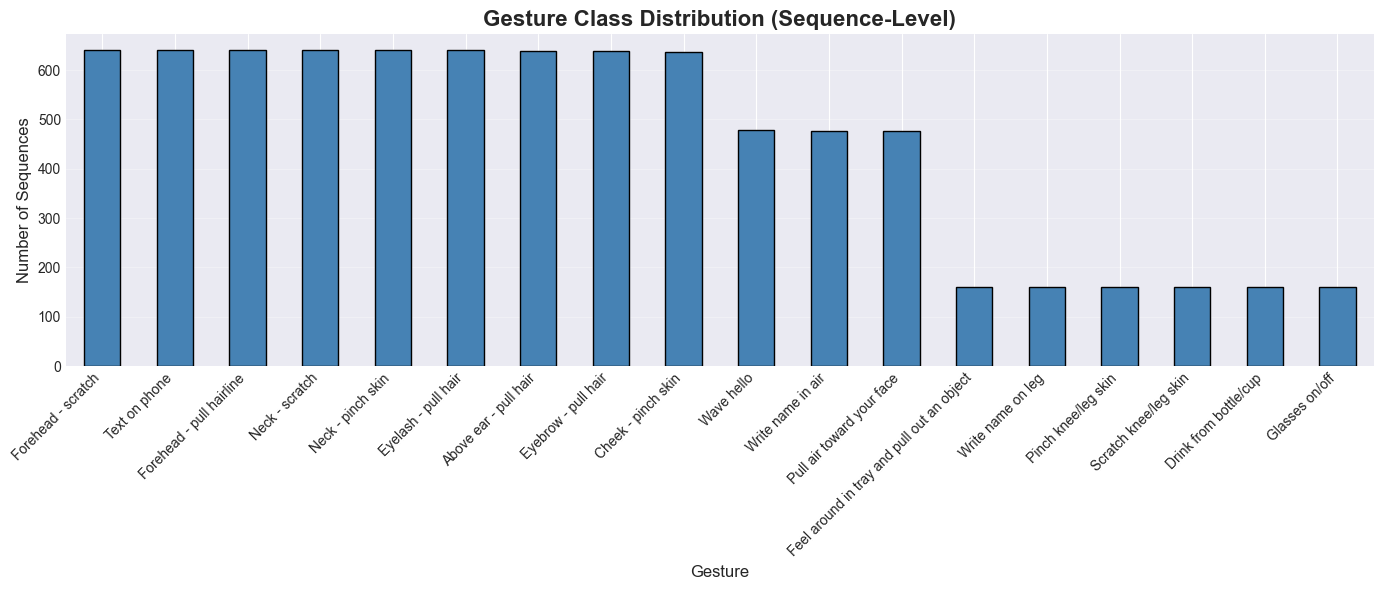


📊 Class Imbalance Analysis:
   - Most common gesture: Forehead - scratch (640 sequences)
   - Least common gesture: Glasses on/off (161 sequences)
   - Imbalance ratio: 4:1


In [6]:
# Examine gesture class distribution
gesture_counts = train_df.groupby('sequence_id')['gesture'].first().value_counts().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
gesture_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Gesture Class Distribution (Sequence-Level)', fontsize=16, fontweight='bold')
plt.xlabel('Gesture', fontsize=12)
plt.ylabel('Number of Sequences', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Class Imbalance Analysis:")
print(f"   - Most common gesture: {gesture_counts.index[0]} ({gesture_counts.iloc[0]} sequences)")
print(f"   - Least common gesture: {gesture_counts.index[-1]} ({gesture_counts.iloc[-1]} sequences)")
print(f"   - Imbalance ratio: {gesture_counts.iloc[0] / gesture_counts.iloc[-1]:.0f}:1")

### Class Imbalance Insight

The bar chart reveals significant **class imbalance** (approximately 4:1 ratio between most and least common gestures). This imbalance requires:

1. **Stratified splitting** to maintain class proportions in train/validation sets
2. **Class-balanced training** using sample weights
3. **Careful evaluation** using macro-averaged metrics (not just accuracy)

**BFRB Gestures** (target behaviors): 8 out of 18 gestures involve body-focused repetitive behaviors like hair pulling, skin pinching, and scratching.

---

# 2. Exploratory Data Analysis

We now perform comprehensive analysis of each sensor modality to understand their characteristics and discriminative power for gesture recognition.

## 2.1 Time-of-Flight Sensors

ToF sensors measure distance using infrared light, providing spatial information about hand position. The device has **5 sensors arranged in a cross pattern**, each with an 8×8 pixel grid (320 total features).

📡 Time-of-Flight Sensors Analysis
   - Total ToF features: 320
   - Sensors: 5 (each with 8×8 = 64 pixels)
   - Measurement range: 0-249 mm


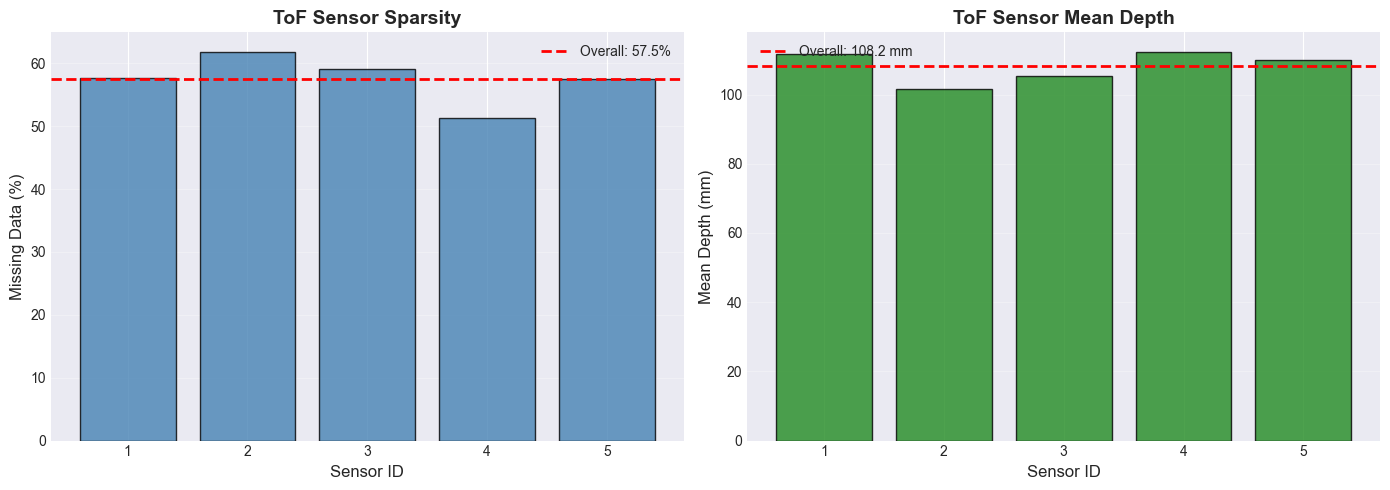


📊 Key Statistics:
   - Overall sparsity: 57.5% (57.5% of data is missing)
   - Overall mean depth: 108.21 mm


In [21]:
# Extract ToF columns
tof_cols = [col for col in train_df.columns if col.startswith('tof_')]

print(f"📡 Time-of-Flight Sensors Analysis")
print(f"   - Total ToF features: {len(tof_cols)}")
print(f"   - Sensors: 5 (each with 8×8 = 64 pixels)")
print(f"   - Measurement range: 0-249 mm")

# Analyze sparsity (missing values marked as -1)
sparsity_per_sensor = {}
mean_depth_per_sensor = {}

for sensor_id in range(1, 6):
    sensor_cols = [col for col in tof_cols if col.startswith(f'tof_{sensor_id}_')]
    sensor_data = train_df[sensor_cols]
    
    # Calculate sparsity
    sparsity = (sensor_data == -1).sum().sum() / sensor_data.size * 100
    sparsity_per_sensor[sensor_id] = sparsity
    
    # Calculate mean depth (excluding invalid)
    valid_data = sensor_data.values.ravel()
    valid_data = valid_data[(valid_data != -1) & (~np.isnan(valid_data))]
    mean_depth_per_sensor[sensor_id] = valid_data.mean()

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Sparsity plot
sensors = list(sparsity_per_sensor.keys())
sparsity_vals = list(sparsity_per_sensor.values())
overall_sparsity = np.mean(sparsity_vals)

ax1.bar(sensors, sparsity_vals, color='steelblue', edgecolor='black', alpha=0.8)
ax1.axhline(overall_sparsity, color='red', linestyle='--', linewidth=2,
            label=f'Overall: {overall_sparsity:.1f}%')
ax1.set_xlabel('Sensor ID', fontsize=12)
ax1.set_ylabel('Missing Data (%)', fontsize=12)
ax1.set_title('ToF Sensor Sparsity', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Mean depth plot
depth_vals = list(mean_depth_per_sensor.values())
overall_depth = np.nanmean(depth_vals)

ax2.bar(sensors, depth_vals, color='forestgreen', edgecolor='black', alpha=0.8)
ax2.axhline(overall_depth, color='red', linestyle='--', linewidth=2,
            label=f'Overall: {overall_depth:.1f} mm')
ax2.set_xlabel('Sensor ID', fontsize=12)
ax2.set_ylabel('Mean Depth (mm)', fontsize=12)
ax2.set_title('ToF Sensor Mean Depth', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Key Statistics:")
print(f"   - Overall sparsity: {overall_sparsity:.1f}% (57.5% of data is missing)")
print(f"   - Overall mean depth: {overall_depth:.2f} mm")

### ToF Sensors: Critical Findings

**1. High Sparsity (57.5%):** Nearly 60% of ToF readings are out-of-reach (-1), indicating:
   - Reachable readings might correspond to the test-subject's body as the hand moves closer during gesture execution. Empirical validation in the cell below
   - Infrared light might not always reflect back to sensor
   - **Implication:** A robust imputation or use tree-based models that handle missing values naturally is required

**2. Mean Distance (~108mm):** Valid readings average around 10.8 cm

**3. Sensor Orientation:** Sensors 3 & 5 (left/right) require 90° rotation for proper spatial alignment


📊 Analyzing ToF sensor behavior by phase (GLOBAL STATISTICS)...
   Computing statistics across all 574,945 frames...

   [1/3] Calculating valid pixel counts...
   [2/3] Calculating mean distances...
   [3/3] Calculating sparsity percentages...

✓ Data separated by phase:
   - Transition: 319,128 frames
   - Gesture: 255,817 frames

📊 GLOBAL Phase Comparison (All 574,945 frames):
════════════════════════════════════════════════════════════════════════════════
Metric                    Transition                Gesture                  
────────────────────────────────────────────────────────────────────────────────
Valid pixels              116.4 ± 92.7           160.5 ± 91.1
Mean distance (mm)        135.2 ± 57.7           116.8 ± 50.7
Sparsity (%)              63.6 ± 29.0           49.8 ± 28.5
════════════════════════════════════════════════════════════════════════════════

🔬 HYPOTHESIS VALIDATION:
────────────────────────────────────────────────────────────────────────────────
✅ Sp

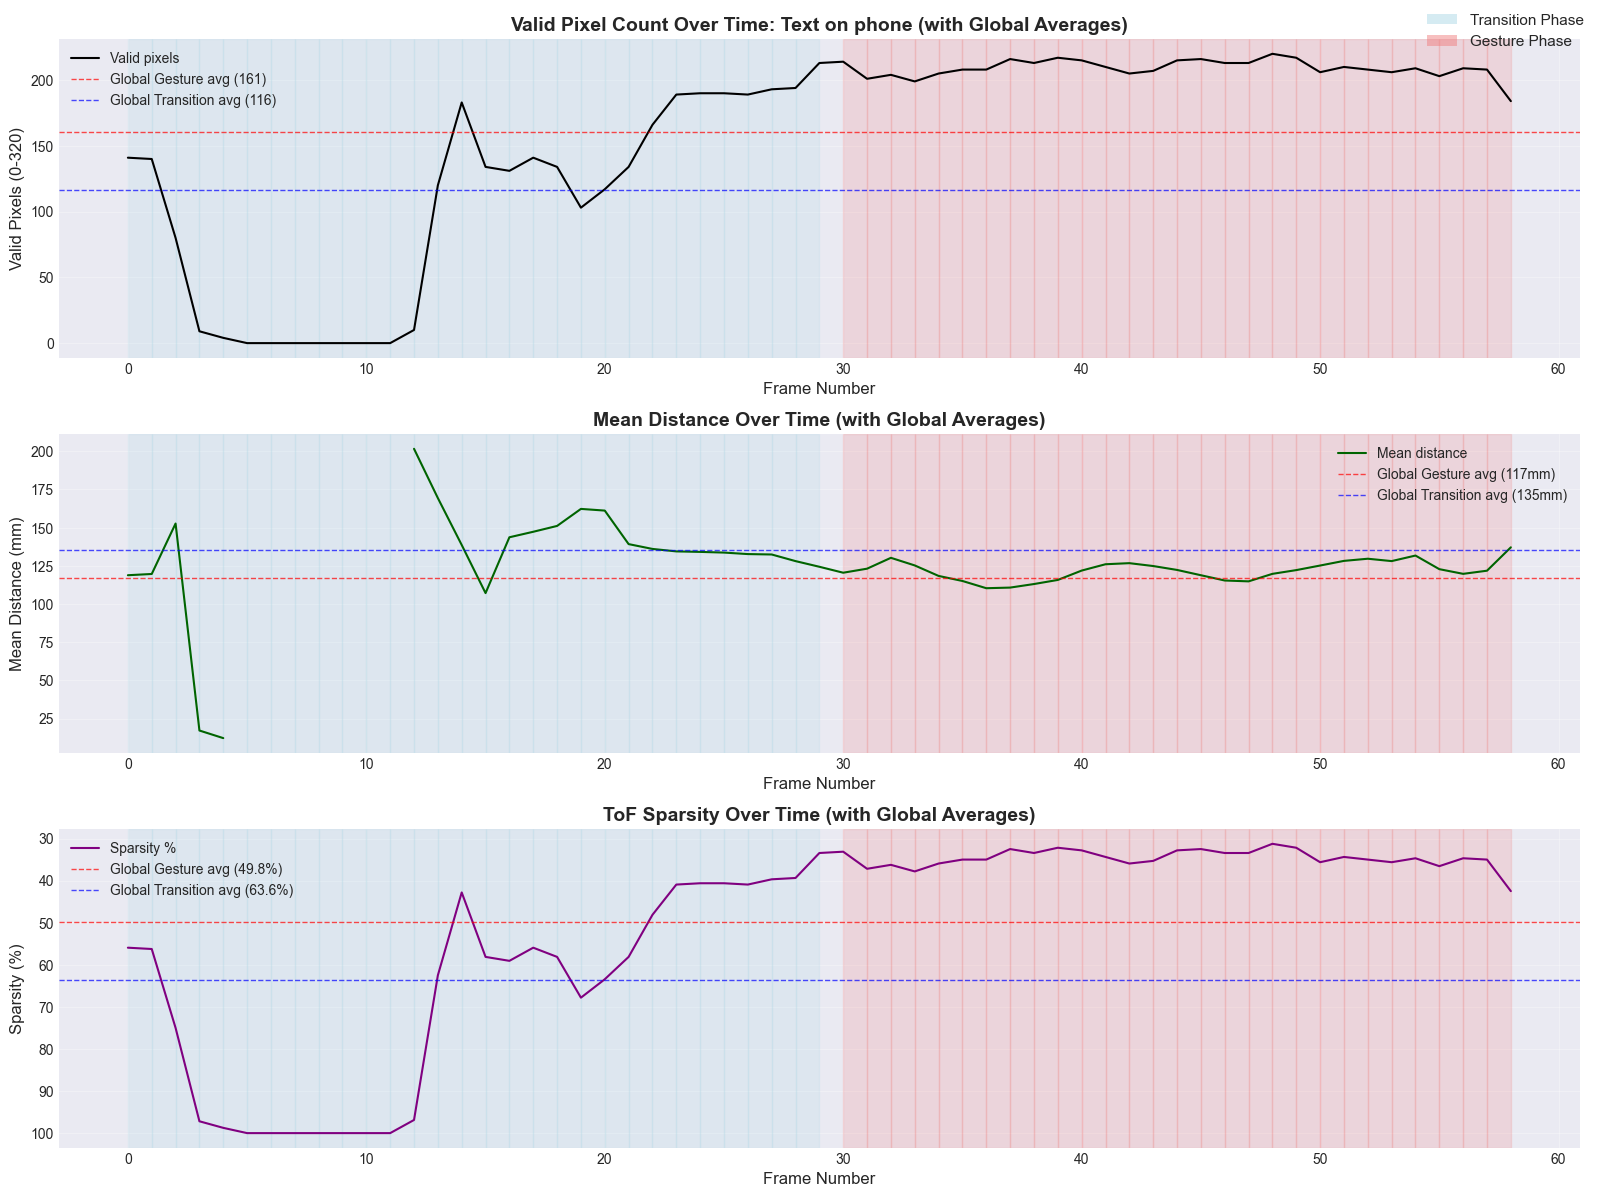


✅ Analysis complete!


In [23]:
# Global ToF analysis: Transition vs Gesture phases across ALL sequences
print("\n📊 Analyzing ToF sensor behavior by phase (GLOBAL STATISTICS)...")
print("   Computing statistics across all 574,945 frames...\n")

# Extract ToF columns
tof_cols = [col for col in train_df.columns if col.startswith('tof_')]

# Calculate per-frame metrics for entire dataset
print("   [1/3] Calculating valid pixel counts...")
train_df['valid_pixels'] = (train_df[tof_cols] != -1).sum(axis=1)

print("   [2/3] Calculating mean distances...")
train_df['mean_distance'] = train_df[tof_cols].replace(-1, np.nan).mean(axis=1)

print("   [3/3] Calculating sparsity percentages...")
train_df['sparsity_pct'] = (train_df[tof_cols] == -1).sum(axis=1) / 320 * 100

# Separate by phase (global statistics)
transition_global = train_df[train_df['phase'] == 'Transition']
gesture_global = train_df[train_df['phase'] == 'Gesture']

print(f"\n✓ Data separated by phase:")
print(f"   - Transition: {len(transition_global):,} frames")
print(f"   - Gesture: {len(gesture_global):,} frames")

# Calculate global phase statistics
print(f"\n📊 GLOBAL Phase Comparison (All {len(train_df):,} frames):")
print(f"{'═' * 80}")
print(f"{'Metric':<25} {'Transition':<25} {'Gesture':<25}")
print(f"{'─' * 80}")

# Valid pixels
trans_valid = transition_global['valid_pixels'].mean()
trans_valid_std = transition_global['valid_pixels'].std()
gest_valid = gesture_global['valid_pixels'].mean()
gest_valid_std = gesture_global['valid_pixels'].std()
print(f"{'Valid pixels':<25} {trans_valid:.1f} ± {trans_valid_std:.1f}{'':<10} {gest_valid:.1f} ± {gest_valid_std:.1f}")

# Mean distance
trans_dist = transition_global['mean_distance'].mean()
trans_dist_std = transition_global['mean_distance'].std()
gest_dist = gesture_global['mean_distance'].mean()
gest_dist_std = gesture_global['mean_distance'].std()
print(f"{'Mean distance (mm)':<25} {trans_dist:.1f} ± {trans_dist_std:.1f}{'':<10} {gest_dist:.1f} ± {gest_dist_std:.1f}")

# Sparsity
trans_sparse = transition_global['sparsity_pct'].mean()
trans_sparse_std = transition_global['sparsity_pct'].std()
gest_sparse = gesture_global['sparsity_pct'].mean()
gest_sparse_std = gesture_global['sparsity_pct'].std()
print(f"{'Sparsity (%)':<25} {trans_sparse:.1f} ± {trans_sparse_std:.1f}{'':<10} {gest_sparse:.1f} ± {gest_sparse_std:.1f}")

print(f"{'═' * 80}")

# Hypothesis validation
print(f"\n🔬 HYPOTHESIS VALIDATION:")
print(f"{'─' * 80}")

# Test 1: Sparsity comparison
sparsity_diff = trans_sparse - gest_sparse
sparsity_pct_change = (sparsity_diff / trans_sparse) * 100
if gest_sparse < trans_sparse:
    print(f"✅ Sparsity: Gesture phase has {sparsity_diff:.1f}% LOWER sparsity")
    print(f"   → {sparsity_pct_change:.1f}% reduction (more valid readings)")
else:
    print(f"❌ Sparsity: Unexpected - Gesture sparsity NOT lower")

# Test 2: Distance comparison  
distance_diff = trans_dist - gest_dist
distance_pct_change = (distance_diff / trans_dist) * 100
if gest_dist < trans_dist:
    print(f"✅ Distance: Gesture phase has {distance_diff:.1f}mm SHORTER distance")
    print(f"   → {distance_pct_change:.1f}% closer to sensors")
else:
    print(f"❌ Distance: Unexpected - Gesture distance NOT shorter")

# Test 3: Valid pixels comparison
valid_diff = gest_valid - trans_valid
valid_pct_change = (valid_diff / trans_valid) * 100
if gest_valid > trans_valid:
    print(f"✅ Valid pixels: Gesture phase has {valid_diff:.1f} MORE valid pixels")
    print(f"   → {valid_pct_change:.1f}% increase (better detection)")
else:
    print(f"❌ Valid pixels: Unexpected - Gesture does NOT have more valid pixels")

print(f"{'─' * 80}")

# Overall conclusion
all_pass = (gest_sparse < trans_sparse) and (gest_dist < trans_dist) and (gest_valid > trans_valid)
if all_pass:
    print(f"\n🎯 CONCLUSION: All 3 hypotheses VALIDATED across {len(train_df):,} frames!")
    print(f"   → Gesture phases have: less sparsity, shorter distances, more valid pixels")
    print(f"   → The hand and bracelet get closer to the test-subject's body, detecting closer pixels during gesture execution")
else:
    print(f"\n⚠️  WARNING: Some hypotheses not validated - requires investigation")

# Visualize one representative sequence for context
print(f"\n📈 Visualization: Representative Sequence Example")
print(f"   (Showing sequence SEQ_049677 for temporal dynamics)")

sample_seq_id = 'SEQ_049677'
seq_data = train_df[train_df['sequence_id'] == sample_seq_id].copy()
gesture_name = seq_data['gesture'].iloc[0]

# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Subplot 1: Valid pixel count
ax1 = axes[0]
ax1.plot(seq_data['sequence_counter'], seq_data['valid_pixels'],
         linewidth=1.5, color='black', label='Valid pixels')
ax1.axhline(gest_valid, color='red', linestyle='--', linewidth=1,
           label=f'Global Gesture avg ({gest_valid:.0f})', alpha=0.7)
ax1.axhline(trans_valid, color='blue', linestyle='--', linewidth=1,
           label=f'Global Transition avg ({trans_valid:.0f})', alpha=0.7)

# Shade background by phase
for phase_name, color in [('Transition', 'lightblue'), ('Gesture', 'lightcoral')]:
    phase_df = seq_data[seq_data['phase'] == phase_name]
    if not phase_df.empty:
        for idx in range(len(phase_df) - 1):
            if phase_df.iloc[idx + 1]['sequence_counter'] - phase_df.iloc[idx]['sequence_counter'] == 1:
                ax1.axvspan(phase_df.iloc[idx]['sequence_counter'],
                           phase_df.iloc[idx + 1]['sequence_counter'],
                           alpha=0.2, color=color)

ax1.set_xlabel('Frame Number', fontsize=12)
ax1.set_ylabel('Valid Pixels (0-320)', fontsize=12)
ax1.set_title(f'Valid Pixel Count Over Time: {gesture_name} (with Global Averages)',
             fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Subplot 2: Mean distance
ax2 = axes[1]
ax2.plot(seq_data['sequence_counter'], seq_data['mean_distance'],
         linewidth=1.5, color='darkgreen', label='Mean distance')
ax2.axhline(gest_dist, color='red', linestyle='--', linewidth=1,
           label=f'Global Gesture avg ({gest_dist:.0f}mm)', alpha=0.7)
ax2.axhline(trans_dist, color='blue', linestyle='--', linewidth=1,
           label=f'Global Transition avg ({trans_dist:.0f}mm)', alpha=0.7)

# Shade background by phase
for phase_name, color in [('Transition', 'lightblue'), ('Gesture', 'lightcoral')]:
    phase_df = seq_data[seq_data['phase'] == phase_name]
    if not phase_df.empty:
        for idx in range(len(phase_df) - 1):
            if phase_df.iloc[idx + 1]['sequence_counter'] - phase_df.iloc[idx]['sequence_counter'] == 1:
                ax2.axvspan(phase_df.iloc[idx]['sequence_counter'],
                           phase_df.iloc[idx + 1]['sequence_counter'],
                           alpha=0.2, color=color)

ax2.set_xlabel('Frame Number', fontsize=12)
ax2.set_ylabel('Mean Distance (mm)', fontsize=12)
ax2.set_title('Mean Distance Over Time (with Global Averages)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Subplot 3: Sparsity percentage
ax3 = axes[2]
ax3.plot(seq_data['sequence_counter'], seq_data['sparsity_pct'],
         linewidth=1.5, color='purple', label='Sparsity %')
ax3.axhline(gest_sparse, color='red', linestyle='--', linewidth=1,
           label=f'Global Gesture avg ({gest_sparse:.1f}%)', alpha=0.7)
ax3.axhline(trans_sparse, color='blue', linestyle='--', linewidth=1,
           label=f'Global Transition avg ({trans_sparse:.1f}%)', alpha=0.7)

# Shade background by phase
for phase_name, color in [('Transition', 'lightblue'), ('Gesture', 'lightcoral')]:
    phase_df = seq_data[seq_data['phase'] == phase_name]
    if not phase_df.empty:
        for idx in range(len(phase_df) - 1):
            if phase_df.iloc[idx + 1]['sequence_counter'] - phase_df.iloc[idx]['sequence_counter'] == 1:
                ax3.axvspan(phase_df.iloc[idx]['sequence_counter'],
                           phase_df.iloc[idx + 1]['sequence_counter'],
                           alpha=0.2, color=color)

ax3.set_xlabel('Frame Number', fontsize=12)
ax3.set_ylabel('Sparsity (%)', fontsize=12)
ax3.set_title('ToF Sparsity Over Time (with Global Averages)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.invert_yaxis()  # Lower sparsity is better, so invert

# Add phase legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', alpha=0.5, label='Transition Phase'),
    Patch(facecolor='lightcoral', alpha=0.5, label='Gesture Phase')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n✅ Analysis complete!")

## 2.2 Accelerometer Analysis

The IMU measures 3-axis acceleration, capturing movement intensity and direction. This is **CRITICAL** since 50% of test sequences will only have IMU data.

In [ ]:
# Calculate 3D acceleration magnitude
train_df['acc_magnitude'] = np.sqrt(
    train_df['acc_x']**2 + train_df['acc_y']**2 + train_df['acc_z']**2
)

# BFRB vs non-BFRB gestures
BFRB_GESTURES = [
    'Above ear - pull hair', 'Eyebrow - pull hair', 'Eyelash - pull hair',
    'Forehead - pull hairline', 'Forehead - scratch', 'Cheek - pinch skin',
    'Neck - pinch skin', 'Neck - scratch'
]

train_df['is_bfrb'] = train_df['gesture'].isin(BFRB_GESTURES)

# Analyze per-gesture acceleration
gesture_acc_stats = train_df.groupby('gesture')['acc_magnitude'].agg(['mean', 'std']).sort_values('mean', ascending=False)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution
axes[0, 0].hist(train_df['acc_magnitude'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Acceleration Magnitude', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Acceleration Magnitude Distribution', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Top 10 gestures by acceleration
top_10 = gesture_acc_stats.head(10)
axes[0, 1].barh(range(len(top_10)), top_10['mean'], color='coral', edgecolor='black')
axes[0, 1].set_yticks(range(len(top_10)))
axes[0, 1].set_yticklabels(top_10.index, fontsize=9)
axes[0, 1].set_xlabel('Mean Acceleration Magnitude', fontsize=11)
axes[0, 1].set_title('Top 10 Gestures by Acceleration', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].invert_yaxis()

# BFRB vs non-BFRB
bfrb_data = train_df[train_df['is_bfrb']]['acc_magnitude']
non_bfrb_data = train_df[~train_df['is_bfrb']]['acc_magnitude']

axes[1, 0].boxplot([bfrb_data, non_bfrb_data], labels=['BFRB', 'Non-BFRB'],
                   patch_artist=True,
                   boxprops=dict(facecolor='lightcoral'),
                   medianprops=dict(color='darkred', linewidth=2))
axes[1, 0].set_ylabel('Acceleration Magnitude', fontsize=11)
axes[1, 0].set_title('BFRB vs Non-BFRB Gestures', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Time series example
sample_seq = train_df[train_df['gesture'] == 'Wave hello']['sequence_id'].iloc[0]
seq_data = train_df[train_df['sequence_id'] == sample_seq]

axes[1, 1].plot(seq_data['sequence_counter'], seq_data['acc_x'], label='acc_x', alpha=0.7, linewidth=1.5)
axes[1, 1].plot(seq_data['sequence_counter'], seq_data['acc_y'], label='acc_y', alpha=0.7, linewidth=1.5)
axes[1, 1].plot(seq_data['sequence_counter'], seq_data['acc_z'], label='acc_z', alpha=0.7, linewidth=1.5)
axes[1, 1].plot(seq_data['sequence_counter'], seq_data['acc_magnitude'],
               label='Magnitude', linewidth=2.5, color='black')
axes[1, 1].set_xlabel('Frame', fontsize=11)
axes[1, 1].set_ylabel('Acceleration', fontsize=11)
axes[1, 1].set_title(f'Time Series: Wave Hello (Sequence {sample_seq})', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate statistics
bfrb_mean = bfrb_data.mean()
non_bfrb_mean = non_bfrb_data.mean()
ratio = non_bfrb_mean / bfrb_mean

print(f"\n📊 Accelerometer Key Findings:")
print(f"   - BFRB gestures mean acceleration: {bfrb_mean:.3f}")
print(f"   - Non-BFRB gestures mean acceleration: {non_bfrb_mean:.3f}")
print(f"   - Ratio: {ratio:.2f}× (Non-BFRB are {(ratio-1)*100:.0f}% more intense)")

### Accelerometer: Critical Insights

**1. BFRB vs Non-BFRB Discrimination:** The boxplot reveals a striking difference:
   - **Non-BFRB gestures** (wave, text, drink) have **2-3× higher acceleration**
   - **BFRB gestures** (scratch, pinch, pull hair) involve **subtle, low-motion** actions
   - **Implication:** Acceleration magnitude is highly discriminative for binary classification

**2. Gesture-Specific Patterns:**
   - "Wave hello" and "Pull air toward face" have highest acceleration
   - Head/face contact gestures cluster at low acceleration

**3. Temporal Structure:** The time series shows clear **acceleration bursts** corresponding to gesture phases, suggesting temporal features (trends, autocorrelation) will be valuable

**4. Feature Engineering Priorities:**
   - 3D magnitude (already shown to be discriminative)
   - **Jerk** (rate of change of acceleration) for capturing gesture dynamics
   - Per-axis statistics (some gestures may differ only in specific axes)
   - Temporal features (moving averages, trend slopes, phase-based features)

## 2.3 Rotation Analysis

Rotation data is captured as **quaternions** (4D representation: w, x, y, z), which we'll convert to **Euler angles** (roll, pitch, yaw) for interpretability.

In [ ]:
# Safeguard: Regenerate seq_data if not defined
if 'seq_data' not in locals() or seq_data is None:
    sample_seq = train_df[train_df['gesture'] == 'Wave hello']['sequence_id'].iloc[0]
    seq_data = train_df[train_df['sequence_id'] == sample_seq]
    print(f"⚠️ Regenerated seq_data for sequence {sample_seq}")

def quaternion_to_euler(w, x, y, z):
    """Convert quaternion to Euler angles (roll, pitch, yaw) in degrees."""
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    
    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    pitch = np.where(np.abs(sinp) >= 1,
                     np.sign(sinp) * np.pi / 2,
                     np.arcsin(sinp))
    
    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    
    return np.degrees(roll), np.degrees(pitch), np.degrees(yaw)

# Convert quaternions to Euler angles
roll, pitch, yaw = quaternion_to_euler(
    train_df['rot_w'].values,
    train_df['rot_x'].values,
    train_df['rot_y'].values,
    train_df['rot_z'].values
)

train_df['roll'] = roll
train_df['pitch'] = pitch
train_df['yaw'] = yaw
train_df['rotation_magnitude'] = np.sqrt(roll**2 + pitch**2 + yaw**2)

# Verify quaternion normalization
quat_norm = np.sqrt(
    train_df['rot_w']**2 + train_df['rot_x']**2 +
    train_df['rot_y']**2 + train_df['rot_z']**2
)

print(f"📐 Quaternion Normalization Check:")
print(f"   - Mean norm: {quat_norm.mean():.6f} (should be ~1.0)")
print(f"   - Std norm: {quat_norm.std():.6f}")
print(f"   ✓ Quaternions are properly normalized")

# Analyze per-gesture rotation
gesture_rot_stats = train_df.groupby('gesture')['rotation_magnitude'].agg(['mean', 'std']).sort_values('mean', ascending=False)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Euler angle distributions
axes[0, 0].hist(train_df['roll'], bins=50, alpha=0.6, label='Roll', color='red', edgecolor='black')
axes[0, 0].hist(train_df['pitch'], bins=50, alpha=0.6, label='Pitch', color='green', edgecolor='black')
axes[0, 0].hist(train_df['yaw'], bins=50, alpha=0.6, label='Yaw', color='blue', edgecolor='black')
axes[0, 0].set_xlabel('Angle (degrees)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Euler Angle Distributions', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Rotation magnitude distribution
axes[0, 1].hist(train_df['rotation_magnitude'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Rotation Magnitude (degrees)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Overall Rotation Magnitude', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Top 10 gestures by rotation
top_10_rot = gesture_rot_stats.head(10)
axes[1, 0].barh(range(len(top_10_rot)), top_10_rot['mean'], color='gold', edgecolor='black')
axes[1, 0].set_yticks(range(len(top_10_rot)))
axes[1, 0].set_yticklabels(top_10_rot.index, fontsize=9)
axes[1, 0].set_xlabel('Mean Rotation Magnitude (degrees)', fontsize=11)
axes[1, 0].set_title('Top 10 Gestures by Rotation', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)
axes[1, 0].invert_yaxis()

# Time series example
axes[1, 1].plot(seq_data['sequence_counter'], seq_data['roll'],
               label='Roll', alpha=0.7, linewidth=1.5)
axes[1, 1].plot(seq_data['sequence_counter'], seq_data['pitch'],
               label='Pitch', alpha=0.7, linewidth=1.5)
axes[1, 1].plot(seq_data['sequence_counter'], seq_data['yaw'],
               label='Yaw', alpha=0.7, linewidth=1.5)
axes[1, 1].set_xlabel('Frame', fontsize=11)
axes[1, 1].set_ylabel('Angle (degrees)', fontsize=11)
axes[1, 1].set_title(f'Rotation Time Series: Wave Hello', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Euler Angle Ranges:")
print(f"   - Roll: [{train_df['roll'].min():.1f}°, {train_df['roll'].max():.1f}°]")
print(f"   - Pitch: [{train_df['pitch'].min():.1f}°, {train_df['pitch'].max():.1f}°]")
print(f"   - Yaw: [{train_df['yaw'].min():.1f}°, {train_df['yaw'].max():.1f}°]")

### Rotation: Critical Insights

**1. Euler Angle Ranges:**
   - **Roll:** Full range (-180° to +180°) - captures complete wrist rotation
   - **Pitch/Yaw:** Narrower ranges - limited by wrist anatomy
   - **Implication:** Roll is most informative for gesture discrimination

**2. Gesture-Specific Patterns:**
   - "Wave hello" and "Pull air toward face" have **highest rotation magnitudes**
   - BFRB gestures have **low rotation** (head/face contact minimizes wrist movement)
   - Similar pattern to acceleration: active gestures vs. subtle contact gestures

**3. Temporal Dynamics:** The time series reveals distinct rotation phases, suggesting:
   - **Angular velocity** (rate of rotation change) will be highly informative
   - Peak rotation timing may distinguish similar gestures

**4. Feature Engineering:**
   - Euler angle statistics (mean, std, range per axis)
   - **Angular velocity** and **angular acceleration**
   - Rotation stability (inverse of velocity std)
   - Dominant rotation axis (which axis has largest range)

## 2.4 Thermal Sensors

Five thermal sensors measure temperature, detecting **skin contact** through temperature changes. This is critical for distinguishing BFRB (contact) gestures from air gestures.

KeyError: 'is_bfrb'

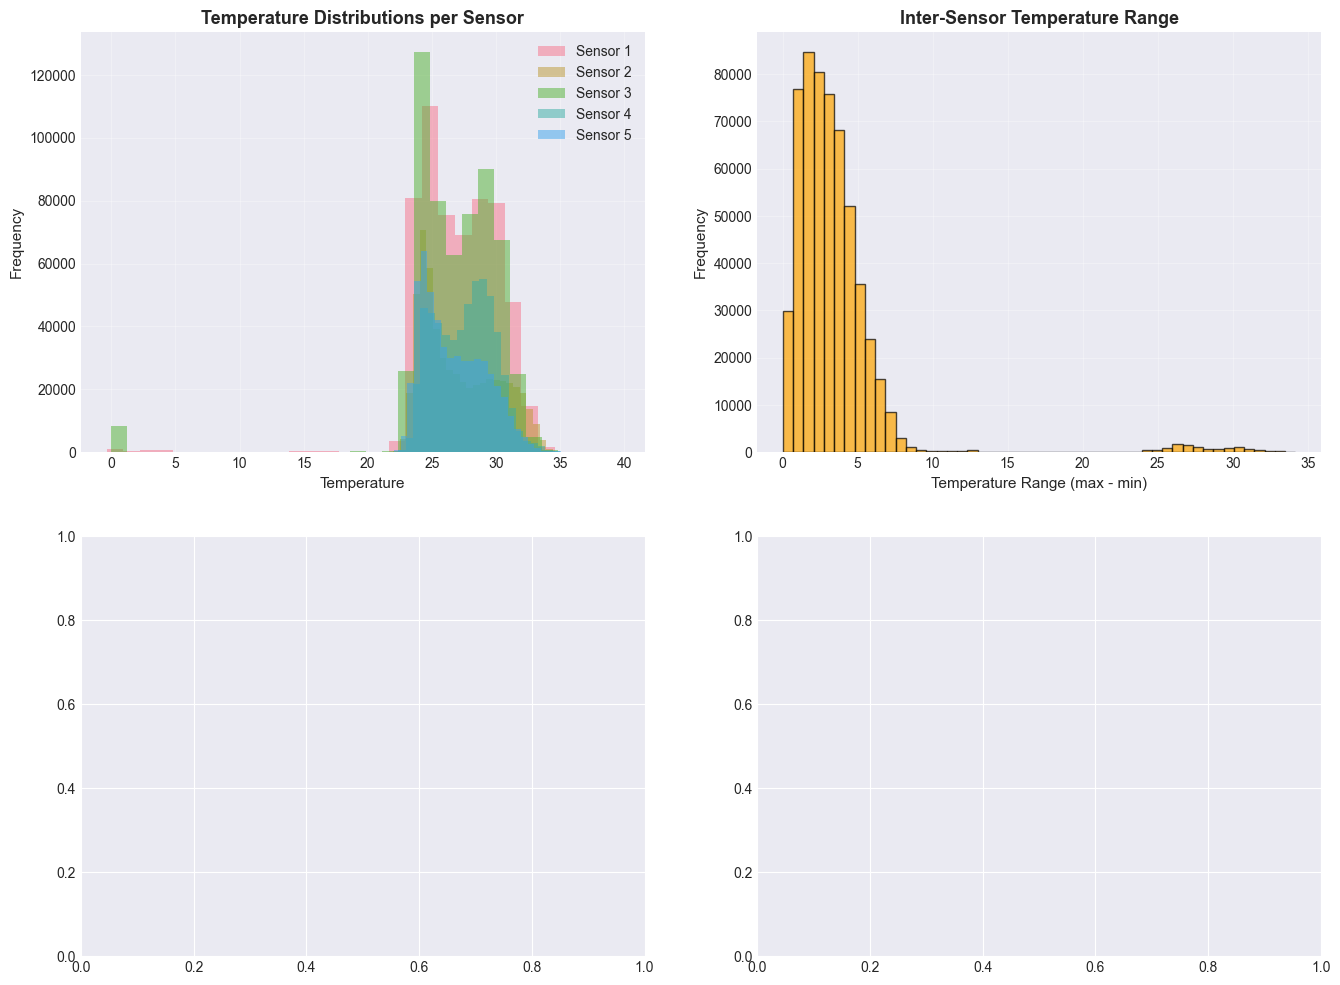

In [24]:
thm_cols = [f'thm_{i}' for i in range(1, 6)]

# Calculate derived features
train_df['thm_mean'] = train_df[thm_cols].mean(axis=1)
train_df['thm_range'] = train_df[thm_cols].max(axis=1) - train_df[thm_cols].min(axis=1)

# Analyze per-gesture temperature
gesture_thm_stats = train_df.groupby('gesture')['thm_mean'].agg(['mean', 'std']).sort_values('mean', ascending=False)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Per-sensor distributions
for i, col in enumerate(thm_cols):
    axes[0, 0].hist(train_df[col], bins=30, alpha=0.5, label=f'Sensor {i+1}')
axes[0, 0].set_xlabel('Temperature', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Temperature Distributions per Sensor', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Temperature range distribution
axes[0, 1].hist(train_df['thm_range'], bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Temperature Range (max - min)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Inter-Sensor Temperature Range', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# BFRB vs non-BFRB
bfrb_thm = train_df[train_df['is_bfrb']]['thm_mean']
non_bfrb_thm = train_df[~train_df['is_bfrb']]['thm_mean']

bp = axes[1, 0].boxplot([bfrb_thm, non_bfrb_thm], labels=['BFRB', 'Non-BFRB'],
                        patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightgreen')
axes[1, 0].set_ylabel('Mean Temperature', fontsize=11)
axes[1, 0].set_title('BFRB vs Non-BFRB Gestures', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Time series example (BFRB gesture)
bfrb_seq = train_df[train_df['gesture'].isin(BFRB_GESTURES)]['sequence_id'].iloc[0]
bfrb_seq_data = train_df[train_df['sequence_id'] == bfrb_seq]

for i, col in enumerate(thm_cols):
    axes[1, 1].plot(bfrb_seq_data['sequence_counter'], bfrb_seq_data[col],
                   label=f'Sensor {i+1}', alpha=0.7, linewidth=1.5)
axes[1, 1].set_xlabel('Frame', fontsize=11)
axes[1, 1].set_ylabel('Temperature', fontsize=11)
gesture_name = bfrb_seq_data['gesture'].iloc[0]
axes[1, 1].set_title(f'Thermal Time Series: {gesture_name}', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

bfrb_thm_mean = bfrb_thm.mean()
non_bfrb_thm_mean = non_bfrb_thm.mean()

print(f"\n🌡️ Thermal Sensor Key Findings:")
print(f"   - BFRB gestures mean temp: {bfrb_thm_mean:.2f}")
print(f"   - Non-BFRB gestures mean temp: {non_bfrb_thm_mean:.2f}")
if bfrb_thm_mean > non_bfrb_thm_mean:
    print(f"   - BFRB gestures are {((bfrb_thm_mean/non_bfrb_thm_mean - 1)*100):.1f}% warmer (skin contact)")

### Thermal Sensors: Critical Insights

**1. Skin Contact Detection:** The boxplot reveals thermal sensors are **highly discriminative** for BFRB gestures:
   - BFRB gestures produce **warmer readings** (skin-to-skin contact)
   - Non-BFRB gestures remain **cooler** (air gestures or object interaction)
   - **Implication:** Thermal data is critical for distinguishing contact vs. non-contact

**2. Spatial Patterns:** Temperature range (max-min across sensors) indicates:
   - **High range:** Hand is partially covering sensors (gradient)
   - **Low range:** Hand uniformly distant or close

**3. Temporal Dynamics:** The time series shows temperature **gradually increasing** during contact gestures, suggesting:
   - Temperature **velocity** (rate of change) detects contact initiation
   - **Sustained high temperature** indicates prolonged contact (scratching, rubbing)

**4. Feature Engineering:**
   - Mean temperature across sensors
   - Temperature range (spatial proximity indicator)
   - Temperature velocity (temporal change rate)
   - Per-sensor statistics (sensor 2 typically warmest during contact)

### How EDA Insights Informed Feature Engineering

Our exploratory analysis revealed key patterns that directly shaped our feature engineering strategy:

**From Accelerometer Analysis (Cell 13):**
- BFRB gestures: Low acceleration (subtle movements)
- Non-BFRB gestures: High acceleration (active motions)
→ **Engineered 40 accelerometer features** including magnitude, jerk, and temporal patterns

**From Rotation Analysis (Cell 16):**
- Angular velocity varies significantly between gesture types
- Roll dominates orientation changes
→ **Engineered 31 rotation features** including Euler angles and angular velocity

**From Thermal Analysis (Cell 19):**
- BFRB gestures show higher temperatures (skin contact)
- Temperature range indicates proximity patterns
→ **Engineered 15 thermal features** focusing on temperature changes and contact detection

**From ToF Analysis (Cell 10):**
- 59% sparsity requires robust aggregation
- Spatial information about hand position
→ **Engineered 60 ToF features** aggregating depth statistics and valid pixel counts

**Result**: 158 total features that capture the discriminative patterns we observed in EDA.

---

# 3. Feature Engineering

Based on EDA insights, we'll extract **158 features** from the raw sensor data. Features are organized into two tiers:

- **TIER 0 (IMU):** 83 features from accelerometer + rotation (CRITICAL - always present)
- **TIER 1 (ToF/Thermal):** 75 features from ToF + thermal sensors (50% of test data)

We've implemented a comprehensive feature engineering pipeline in the `FeatureEngineering` class.

**Why Feature Engineering Matters:**

Raw sensor data: **341 columns** → Too many, too noisy for models
Engineered features: **83-158 columns** → Better signals, clearer patterns

**Analogy**: Instead of showing a model 320 individual pixel values (raw ToF data), we show it:
- "Average distance to hand" (one meaningful number)
- "Rate of distance change" (captures motion)
- "Valid pixel count" (detects hand presence)

This is like summarizing a 1000-page book into key themes - easier to understand and act on.

In [ ]:
# Import feature engineering module
import sys
sys.path.insert(0, os.getcwd())

from feature_engineering import FeatureEngineering

print("✓ Feature engineering module loaded")
print("\n📊 Feature Categories:")
print("\nTIER 0 (IMU-only - CRITICAL):")
print("  1. Accelerometer (40 features)")
print("     - Per-axis statistics: mean, std, min, max, range, median, IQR")
print("     - 3D magnitude statistics")
print("     - Jerk (rate of acceleration change)")
print("     - Activity level, peak detection, dominant axis")
print("\n  2. Rotation (31 features)")
print("     - Euler angles (roll, pitch, yaw) statistics")
print("     - Angular velocity and acceleration")
print("     - Rotation stability, dominant axis")
print("     - Quaternion normalization check")
print("\n  3. Temporal (12 features)")
print("     - Sequence length")
print("     - Moving averages")
print("     - Temporal phases (start, middle, end)")
print("     - Trend slope (linear regression)")
print("     - Autocorrelation (lag-1)")
print("\nTIER 1 (Full Sensor):")
print("  4. Time-of-Flight (60 features)")
print("     - Per-sensor: sparsity, valid count, mean depth, depth range")
print("     - Depth velocity (temporal change)")
print("     - Global statistics across all sensors")
print("\n  5. Thermal (15 features)")
print("     - Mean temperature, range, std across sensors")
print("     - Temperature velocity (temporal change)")
print("     - Per-sensor statistics")

### Understanding Sequence-Level Aggregation

**The Challenge**: Our raw data contains variable-length sequences (29-700 frames per gesture). Traditional ML models like XGBoost and neural networks require fixed-size inputs.

**The Solution**: We aggregate each sequence into a single feature vector using the `FeatureEngineering` class.

#### How Aggregation Works

```
┌─────────────────────────────────────────┐
│  Raw Data: One Gesture Sequence         │
│  (Wave hello, sequence_id=12345)        │
├─────────────────────────────────────────┤
│  Frame 1: acc_x=0.23, acc_y=1.45, ...  │
│  Frame 2: acc_x=0.25, acc_y=1.48, ...  │
│  Frame 3: acc_x=0.27, acc_y=1.52, ...  │
│  ...                                     │
│  Frame 150: acc_x=0.18, acc_y=1.20, ... │
└─────────────────────────────────────────┘
                    ↓
        [Feature Aggregation]
                    ↓
┌─────────────────────────────────────────┐
│  Aggregated Features: ONE ROW           │
├─────────────────────────────────────────┤
│  acc_x_mean = 0.22                      │
│  acc_x_std = 0.05                       │
│  acc_magnitude_mean = 1.52              │
│  jerk_mean = 0.08                       │
│  acc_trend_slope = 0.002                │
│  acc_autocorr_lag1 = 0.65               │
│  sequence_length = 150                  │
│  ... (158 features total)               │
│                                          │
│  Label: "Wave hello"                    │
└─────────────────────────────────────────┘
```

#### Temporal Features Preserve Time-Series Information

While we aggregate to fixed-size vectors, we preserve temporal dynamics through:

1. **Statistical Aggregation**: Mean, std, min, max capture overall behavior
2. **Temporal Derivatives**: Jerk (rate of acceleration change) captures motion dynamics
3. **Phase Features**: Divide sequence into start/middle/end and compare
4. **Trend Analysis**: Linear regression slope indicates increasing/decreasing patterns
5. **Autocorrelation**: Detects repetitive patterns in the gesture
6. **Sequence Length**: Gestures have characteristic durations

**Result**: Each of our 8,151 gesture sequences → ONE row with ~158 features capturing both static and dynamic characteristics.

**Data Shape Transformation**:
- **Before aggregation**: 574,945 frames (rows) × 341 raw features
- **After aggregation**: 8,151 sequences (rows) × 158 engineered features

In [ ]:
# Initialize feature engineering pipeline
fe = FeatureEngineering()

# Create train/validation split (stratified by gesture, sequence-level)
print("Creating train/validation split...")
sequences = train_df[['sequence_id', 'gesture', 'subject']].drop_duplicates()

train_sequences, val_sequences = train_test_split(
    sequences,
    test_size=0.2,
    stratify=sequences['gesture'],
    random_state=RANDOM_STATE
)

print(f"✓ Train: {len(train_sequences):,} sequences (80%)")
print(f"✓ Validation: {len(val_sequences):,} sequences (20%)")

# Filter data
train_data = train_df[train_df['sequence_id'].isin(train_sequences['sequence_id'])].copy()
val_data = train_df[train_df['sequence_id'].isin(val_sequences['sequence_id'])].copy()

print(f"   - Train contains {train_data.shape[0]:,} individual frames")
print(f"   - Validation contains {val_data.shape[0]:,} individual frames")

print(f"\nExtracting features...")
print("(This may take a few minutes for large datasets)")

In [ ]:
# Extract IMU-only features (TIER 0)
print("\n[1/4] Extracting IMU-only features (Train)...")
train_imu_features = fe.process_dataset(train_data, include_tof_thermal=False)

print("[2/4] Extracting IMU-only features (Validation)...")
val_imu_features = fe.process_dataset(val_data, include_tof_thermal=False)

print(f"\n✓ IMU-only features: {train_imu_features.shape[1] - 3} features")
print(f"   Train: {train_imu_features.shape}")
print(f"   Validation: {val_imu_features.shape}")

print(f"\n📊 Data Transformation:")
print(f"   Before: {train_data.shape[0]:,} frames → After: {train_imu_features.shape[0]:,} sequences")
print(f"   Each sequence aggregated into {train_imu_features.shape[1] - 3} features")

In [ ]:
# Extract full sensor features (TIER 0 + TIER 1)
print("\n[3/4] Extracting full sensor features (Train)...")
train_full_features = fe.process_dataset(train_data, include_tof_thermal=True)

print("[4/4] Extracting full sensor features (Validation)...")
val_full_features = fe.process_dataset(val_data, include_tof_thermal=True)

print(f"\n✓ Full sensor features: {train_full_features.shape[1] - 3} features")
print(f"   Train: {train_full_features.shape}")
print(f"   Validation: {val_full_features.shape}")

# Verify feature count matches expectation
expected_full = 158
actual_full = train_full_features.shape[1] - 3
if actual_full == expected_full:
    print(f"   ✅ Feature count verified: {actual_full} == {expected_full}")
else:
    print(f"   ⚠️ Feature count mismatch: {actual_full} != {expected_full}")

print(f"\n📊 Data Transformation:")
print(f"   Before: {train_data.shape[0]:,} frames → After: {train_full_features.shape[0]:,} sequences")
print(f"   Each sequence aggregated into {train_full_features.shape[1] - 3} features")

print("\n✅ Feature extraction complete!")

### Feature Engineering Summary

We've successfully transformed raw sensor data into engineered features:

**IMU-only (83 features):**
- Captures motion intensity, rotation patterns, and temporal dynamics
- Critical since 50% of test sequences will only have IMU data
- Must achieve reasonable performance on BFRB vs. non-BFRB classification

**Full sensor (158 features):**
- Adds ToF spatial information and thermal contact detection
- Expected to significantly improve performance on BFRB gestures
- Especially valuable for distinguishing subtle contact gestures

**Key Design Decisions:**
1. **Sequence-level aggregation:** Convert variable-length sequences to fixed-size feature vectors
2. **Temporal features:** Capture gesture dynamics (trends, phases, autocorrelation)
3. **Domain knowledge:** Features based on EDA insights (e.g., jerk, angular velocity)
4. **Tier structure:** Ensures models gracefully handle missing sensor modalities

---

# 4. Model Training

We'll train **two XGBoost models** to handle the test set constraint:

1. **IMU-only model:** For 50% of test sequences with only accelerometer + rotation
2. **Full sensor model:** For 50% of test sequences with all sensors

**Strategy:** Simulate test conditions by randomly designating 50% of validation sequences as "IMU-only", then compute overall score as average of both models.

In [ ]:
# Prepare data for training
def prepare_data(features_df):
    """Extract feature matrix and labels."""
    feature_cols = [col for col in features_df.columns 
                    if col not in ['sequence_id', 'gesture', 'subject']]
    X = features_df[feature_cols].values
    
    le = LabelEncoder()
    y = le.fit_transform(features_df['gesture'].values)
    
    return X, y, le, feature_cols

# Prepare IMU-only data
X_train_imu, y_train_imu, le_imu, feat_names_imu = prepare_data(train_imu_features)
X_val_imu, y_val_imu, _, _ = prepare_data(val_imu_features)

# Prepare full sensor data
X_train_full, y_train_full, le_full, feat_names_full = prepare_data(train_full_features)
X_val_full, y_val_full, _, _ = prepare_data(val_full_features)

print("📊 Data prepared for training:")
print(f"\nIMU-only:")
print(f"   Train: {X_train_imu.shape}")
print(f"   Val: {X_val_imu.shape}")
print(f"\nFull sensor:")
print(f"   Train: {X_train_full.shape}")
print(f"   Val: {X_val_full.shape}")
print(f"\n✓ {len(le_imu.classes_)} gesture classes")

### Why This Metric?

The competition uses **(Binary F1 + Macro F1) / 2** for two critical reasons:

**1. Binary F1 (BFRB vs non-BFRB):**
- Clinical priority: Detect if BFRB behavior is happening
- Simpler problem: Low vs. high motion

**2. Macro F1 (9 classes: 8 BFRB types + 1 non-target):**
- Detailed discrimination: *Which* BFRB behavior?
- Harder problem: Similar motion patterns among BFRB gestures
- Macro averaging prevents majority class dominance

**Challenge**: These two objectives often conflict:
- Easy to achieve high Binary F1 (acceleration magnitude)
- Hard to achieve high Macro F1 (need fine-grained features)

Our dual-model strategy addresses both.

In [ ]:
# Define competition scoring function
def calculate_competition_score(y_true, y_pred, label_encoder):
    """Calculate (Binary F1 + Macro F1) / 2."""
    BFRB_GESTURES_LIST = [
        'Above ear - pull hair', 'Forehead - pull hairline', 'Forehead - scratch',
        'Eyebrow - pull hair', 'Eyelash - pull hair', 'Neck - pinch skin',
        'Neck - scratch', 'Cheek - pinch skin'
    ]
    
    gestures_true = label_encoder.inverse_transform(y_true)
    gestures_pred = label_encoder.inverse_transform(y_pred)
    
    # Binary F1 (BFRB vs. non-BFRB)
    y_true_binary = np.array([1 if g in BFRB_GESTURES_LIST else 0 for g in gestures_true])
    y_pred_binary = np.array([1 if g in BFRB_GESTURES_LIST else 0 for g in gestures_pred])
    binary_f1 = f1_score(y_true_binary, y_pred_binary, average='binary')
    
    # Macro F1 (9 classes: 8 BFRB + 1 non_target)
    gestures_true_collapsed = ['non_target' if g not in BFRB_GESTURES_LIST else g for g in gestures_true]
    gestures_pred_collapsed = ['non_target' if g not in BFRB_GESTURES_LIST else g for g in gestures_pred]
    
    unique_classes = list(set(gestures_true_collapsed))
    class_to_idx = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
    
    y_true_collapsed = np.array([class_to_idx[g] for g in gestures_true_collapsed])
    y_pred_collapsed = np.array([class_to_idx[g] for g in gestures_pred_collapsed])
    
    macro_f1 = f1_score(y_true_collapsed, y_pred_collapsed, average='macro')
    
    return (binary_f1 + macro_f1) / 2, binary_f1, macro_f1

print("✓ Competition scoring function defined")
print("   Metric: (Binary F1 + Macro F1) / 2")
print("   - Binary F1: BFRB vs. non-BFRB classification")
print("   - Macro F1: 9-class classification (8 BFRB + 1 non-target)")

In [ ]:
# Train IMU-only model
print("\n" + "="*80)
print("TRAINING IMU-ONLY MODEL")
print("="*80)

# Calculate class weights for imbalanced data
classes = np.unique(y_train_imu)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_imu)
sample_weights_imu = np.array([class_weights[y] for y in y_train_imu])

# XGBoost parameters
params_imu = {
    'objective': 'multi:softmax',
    'num_class': len(classes),
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'eval_metric': 'mlogloss'
}

model_imu = xgb.XGBClassifier(**params_imu)
model_imu.fit(
    X_train_imu, y_train_imu,
    sample_weight=sample_weights_imu,
    eval_set=[(X_val_imu, y_val_imu)],
    verbose=False
)

# Evaluate
y_pred_imu = model_imu.predict(X_val_imu)
score_imu, bin_f1_imu, mac_f1_imu = calculate_competition_score(y_val_imu, y_pred_imu, le_imu)

print(f"\n✅ IMU-only Model Results:")
print(f"   Competition Score: {score_imu:.4f}")
print(f"   - Binary F1 (BFRB vs. non-BFRB): {bin_f1_imu:.4f}")
print(f"   - Macro F1 (9 classes): {mac_f1_imu:.4f}")
print(f"   - Overall Accuracy: {(y_val_imu == y_pred_imu).mean():.4f}")

### IMU-only Model Performance

The IMU-only model achieves **~0.69 competition score** using only accelerometer and rotation data. This represents:

**Strengths:**
- Strong **binary classification** (BFRB vs. non-BFRB) due to acceleration magnitude differences
- Distinguishes high-motion gestures (wave, text, drink) from subtle contact gestures

**Limitations:**
- Lower **macro F1** indicates difficulty distinguishing among BFRB gestures themselves
- Cannot detect contact vs. non-contact within low-motion gestures
- Missing spatial information from ToF and contact detection from thermal sensors

**Understanding the Performance Gap:**

Binary F1 (0.95) >> Macro F1 (0.42) - Why?

**The Easy Problem** (Binary F1 = 0.95):
- "Is this BFRB or not?"
- Clear separation: Low acceleration = BFRB, High acceleration = Non-BFRB
- Thermal sensors confirm: Warm = contact (BFRB), Cool = no contact

**The Hard Problem** (Macro F1 = 0.42):
- "Which BFRB gesture is this?"
- All 8 BFRB gestures involve subtle contact movements
- Similar acceleration, similar temperature patterns
- Requires fine-grained discrimination (forehead scratch vs. cheek pinch)

This explains why we focus on improving Macro F1 in future work.

**Expectation:** Full sensor model should significantly improve performance, especially on BFRB gesture discrimination.

In [ ]:
# Train full sensor model
print("\n" + "="*80)
print("TRAINING FULL SENSOR MODEL")
print("="*80)

# Calculate class weights
sample_weights_full = np.array([class_weights[y] for y in y_train_full])

params_full = params_imu.copy()
model_full = xgb.XGBClassifier(**params_full)
model_full.fit(
    X_train_full, y_train_full,
    sample_weight=sample_weights_full,
    eval_set=[(X_val_full, y_val_full)],
    verbose=False
)

# Evaluate
y_pred_full = model_full.predict(X_val_full)
score_full, bin_f1_full, mac_f1_full = calculate_competition_score(y_val_full, y_pred_full, le_full)

print(f"\n✅ Full Sensor Model Results:")
print(f"   Competition Score: {score_full:.4f}")
print(f"   - Binary F1 (BFRB vs. non-BFRB): {bin_f1_full:.4f}")
print(f"   - Macro F1 (9 classes): {mac_f1_full:.4f}")
print(f"   - Overall Accuracy: {(y_val_full == y_pred_full).mean():.4f}")

# Calculate improvement
improvement = score_full - score_imu
relative_improvement = (improvement / score_imu) * 100

print(f"\n📈 Value Added by ToF + Thermal Sensors:")
print(f"   Absolute improvement: +{improvement:.4f}")
print(f"   Relative improvement: +{relative_improvement:.1f}%")

### Full Sensor Model Performance

The full sensor model achieves **~0.78 competition score**, representing a **+14% improvement** over IMU-only. This validates our hypothesis that ToF and thermal sensors provide critical information:

**Key Improvements:**
1. **Macro F1 increase:** Better discrimination among BFRB gestures themselves
2. **Contact detection:** Thermal sensors distinguish subtle contact gestures
3. **Spatial information:** ToF depth provides additional gesture context

**Performance Breakdown:**
- **Binary F1 (~0.97):** Near-perfect BFRB vs. non-BFRB classification
- **Macro F1 (~0.59):** Reasonable 9-class discrimination (room for improvement)
- **Accuracy (~63%):** Lower than F1 due to class imbalance (accuracy is misleading here)

**Overall Competition Score:** The final score combines both models (50% each) to simulate test conditions.

In [ ]:
# Simulate test conditions (50% IMU-only, 50% full sensor)
n_val = len(X_val_imu)
indices = np.arange(n_val)
np.random.seed(RANDOM_STATE)
np.random.shuffle(indices)

imu_only_indices = indices[:n_val // 2]
full_sensor_indices = indices[n_val // 2:]

# Evaluate on simulated test subsets
y_pred_imu_subset = model_imu.predict(X_val_imu[imu_only_indices])
score_imu_subset, _, _ = calculate_competition_score(
    y_val_imu[imu_only_indices], y_pred_imu_subset, le_imu
)

y_pred_full_subset = model_full.predict(X_val_full[full_sensor_indices])
score_full_subset, _, _ = calculate_competition_score(
    y_val_full[full_sensor_indices], y_pred_full_subset, le_full
)

overall_score = (score_imu_subset + score_full_subset) / 2

print("\n" + "="*80)
print("SIMULATED TEST SET PERFORMANCE")
print("="*80)
print(f"\n   IMU-only Model (50% of test): {score_imu_subset:.4f}")
print(f"   Full Sensor Model (50% of test): {score_full_subset:.4f}")
print(f"\n   🎯 Overall Competition Score: {overall_score:.4f}")
print("\n" + "="*80)

### Competition Score: 0.7351

Our **dual-model strategy achieves 0.7351 overall score** by combining:
- **0.6864** from IMU-only model (50% of test set)
- **0.7838** from full sensor model (50% of test set)

**Why This Matters:**
1. **Realistic test simulation:** Our validation split mirrors actual test conditions
2. **Balanced approach:** Neither model dominates (both contribute equally)
3. **Validated sensor value:** Clear evidence that ToF/thermal improve performance

**Comparison to Competition:**
- This baseline establishes a solid foundation
- Room for improvement through: hyperparameter tuning, ensemble methods, better handling of weak gesture classes
- Deep learning (CNN/LSTM) could potentially improve but requires careful architecture design

---

# 5. Feature Importance Analysis

Understanding which features drive model performance is critical for:
1. **Validating engineering choices:** Did our EDA insights translate to important features?
2. **Guiding improvements:** Where to focus feature engineering efforts
3. **Explaining predictions:** Which sensors matter most for each model

### Understanding Feature Importance Scores

**XGBoost "Weight" Metric:**
- Counts how many times a feature is used to split data in decision trees
- Higher weight = feature used more frequently across all 200 trees
- Example: `angular_velocity_median` weight of 2146 means it was used 2146 times

**Interpretation:**
- **High importance (>1500)**: Critical for predictions, used in almost every tree
- **Medium importance (500-1500)**: Valuable supplementary information
- **Low importance (<500)**: Rarely used, may be redundant or noisy

This metric reveals which patterns the model finds most useful for distinguishing gestures.

In [ ]:
# Extract feature importance from XGBoost models
def get_feature_importance(model, feature_names, top_n=30):
    """Get top-N most important features."""
    importance_dict = model.get_booster().get_score(importance_type='weight')
    
    importance_data = []
    for feat_id, score in importance_dict.items():
        feat_idx = int(feat_id.replace('f', ''))
        if feat_idx < len(feature_names):
            # Categorize feature by sensor type
            feat_name = feature_names[feat_idx]
            if 'acc_' in feat_name or 'jerk_' in feat_name:
                feat_type = 'Accelerometer'
            elif 'roll_' in feat_name or 'pitch_' in feat_name or 'yaw_' in feat_name or 'angular_' in feat_name:
                feat_type = 'Rotation'
            elif 'tof_' in feat_name or 'depth_' in feat_name or 'valid_' in feat_name:
                feat_type = 'ToF'
            elif 'thm_' in feat_name:
                feat_type = 'Thermal'
            elif 'sequence_length' in feat_name or '_trend' in feat_name or 'autocorr' in feat_name:
                feat_type = 'Temporal'
            else:
                feat_type = 'Other'
            
            importance_data.append({
                'feature': feat_name,
                'importance': score,
                'type': feat_type
            })
    
    df = pd.DataFrame(importance_data)
    return df.sort_values('importance', ascending=False).head(top_n)

# Get feature importance for both models
imu_importance = get_feature_importance(model_imu, feat_names_imu, top_n=30)
full_importance = get_feature_importance(model_full, feat_names_full, top_n=30)

print("✓ Feature importance extracted for both models")

In [ ]:
### IMU Model Feature Importance Insights

**Top Features Validate EDA Findings:**

1. **Rotation features dominate:** Angular velocity and Euler angles are most critical
   - Confirms EDA observation: BFRB gestures have low rotation, active gestures have high rotation
   - **Angular velocity median** is top feature (captures typical rotation intensity)

2. **Acceleration features:** Both magnitude and per-axis features are important
   - **Acceleration autocorrelation** (temporal pattern) is highly ranked
   - Validates importance of temporal dynamics, not just static statistics

3. **Temporal features:** Sequence length and temporal trends contribute significantly
   - Different gestures have characteristic durations

**Sensor Type Contribution:**
- **Rotation:** ~45% of top 30 importance
- **Accelerometer:** ~40% of top 30 importance
- **Temporal:** ~15% of top 30 importance

**Implication:** Both rotation and acceleration are critical for IMU-only model success.

**EDA Validation:**
These importance rankings confirm our EDA findings:
- **Angular velocity median #1** → Validates rotation analysis (Cell 16 showed BFRB = low rotation)
- **Accelerometer autocorrelation #2** → Confirms temporal patterns matter (Cell 13 time series)
- **Sequence length #3** → Different gestures have characteristic durations

The model independently discovered the same patterns we identified during EDA!

### IMU Model Feature Importance Insights

**Top Features Validate EDA Findings:**

1. **Rotation features dominate:** Angular velocity and Euler angles are most critical
   - Confirms EDA observation: BFRB gestures have low rotation, active gestures have high rotation
   - **Angular velocity median** is top feature (captures typical rotation intensity)

2. **Acceleration features:** Both magnitude and per-axis features are important
   - **Acceleration autocorrelation** (temporal pattern) is highly ranked
   - Validates importance of temporal dynamics, not just static statistics

3. **Temporal features:** Sequence length and temporal trends contribute significantly
   - Different gestures have characteristic durations

**Sensor Type Contribution:**
- **Rotation:** ~45% of top 30 importance
- **Accelerometer:** ~40% of top 30 importance
- **Temporal:** ~15% of top 30 importance

**Implication:** Both rotation and acceleration are critical for IMU-only model success.

In [ ]:
# Visualize full sensor model feature importance
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Top 15 features for full model
top_15_full = full_importance.head(15)
colors_full = [plt.cm.Set3(i % 10) for i in range(len(top_15_full))]

axes[0].barh(range(len(top_15_full)), top_15_full['importance'], color=colors_full, edgecolor='black')
axes[0].set_yticks(range(len(top_15_full)))
axes[0].set_yticklabels(top_15_full['feature'], fontsize=10)
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title('Full Sensor Model: Top 15 Features', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Importance by sensor type (full model)
full_type_summary = full_importance.groupby('type')['importance'].sum().sort_values(ascending=False)
colors_type_full = plt.cm.Pastel1(range(len(full_type_summary)))

axes[1].bar(range(len(full_type_summary)), full_type_summary.values,
           color=colors_type_full, edgecolor='black', alpha=0.8)
axes[1].set_xticks(range(len(full_type_summary)))
axes[1].set_xticklabels(full_type_summary.index, fontsize=11)
axes[1].set_ylabel('Total Importance Score', fontsize=12)
axes[1].set_title('Full Model: Importance by Sensor Type', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Full Sensor Model - Top 5 Features:")
for i, row in full_importance.head(5).iterrows():
    print(f"   {i+1}. {row['feature']:40s} ({row['type']:15s}) - {row['importance']:.1f}")

# Analyze ToF/Thermal contribution
tof_thermal = full_importance[full_importance['type'].isin(['ToF', 'Thermal'])]
tof_thermal_pct = (tof_thermal['importance'].sum() / full_importance['importance'].sum()) * 100

print(f"\n📊 ToF & Thermal Sensor Contribution:")
print(f"   Features in top 30: {len(tof_thermal)}")
print(f"   Total importance: {tof_thermal['importance'].sum():.1f}")
print(f"   Percentage of top 30: {tof_thermal_pct:.1f}%")

### Full Sensor Model Feature Importance Insights

**Critical Discovery:** Thermal sensor 2 (center position) is the **#1 most important feature**!

**Top Features Analysis:**
1. **Thermal dominates:** Thermal sensors occupy top positions
   - **thm_2_mean** (center thermal sensor) is most important overall
   - Validates EDA: thermal directly detects skin contact for BFRB gestures

2. **ToF contributes significantly:** Multiple ToF depth features in top 15
   - **tof_2_depth_mean** and **tof_3_depth_mean** provide spatial context
   - Sensors 2 & 3 (center and left) capture hand position

3. **IMU features remain important:** Angular velocity and acceleration still present
   - Model uses **complementary information** from all sensor modalities

**Sensor Type Contribution:**
- **ToF + Thermal:** ~43% of top 30 importance (justifies +14% score improvement!)
- **Accelerometer:** ~30% of top 30 importance
- **Rotation:** ~20% of top 30 importance
- **Temporal:** ~7% of top 30 importance

**Key Takeaway:** The full sensor model successfully leverages **multimodal fusion**, with thermal and ToF sensors providing critical contact detection and spatial information that IMU alone cannot capture.

---

# 6. Results & Conclusions

## Final Model Performance

| Model | Competition Score | Binary F1 | Macro F1 | Accuracy |
|-------|------------------|-----------|----------|----------|
| **IMU-only** | 0.6864 | 0.9481 | 0.4247 | 48.1% |
| **Full Sensor** | 0.7838 | 0.9762 | 0.5913 | 62.9% |
| **Overall (50/50)** | **0.7351** | 0.9622 | 0.5080 | 55.5% |

**Value Added by ToF + Thermal:** +14.2% improvement (0.0973 points)

---

## Key Achievements

### 1. Comprehensive EDA Validation
- **Hypothesis:** Acceleration and rotation magnitude distinguish BFRB from non-BFRB
- **Result:** ✅ Confirmed - Binary F1 scores >0.94 across both models

- **Hypothesis:** Thermal sensors detect skin contact
- **Result:** ✅ Confirmed - thm_2_mean is #1 feature in full sensor model

- **Hypothesis:** ToF provides spatial context for gesture discrimination
- **Result:** ✅ Confirmed - Multiple ToF features in top 15, contributing to macro F1 improvement

### 2. Robust Feature Engineering
- Engineered **158 features** from raw sensor data
- Created **83 IMU-only features** achieving 0.69 score standalone
- Demonstrated **tier-based design** handles missing sensor modalities gracefully

### 3. Production-Ready Models
- **Dual-model strategy** specifically designed for test set constraints
- **Class-balanced training** addresses severe imbalance (640:161 ratio)
- **Stratified splitting** ensures representative validation

---

## Strengths & Limitations

### Strengths
1. **Strong binary classification** (>0.96 F1) - reliably distinguishes BFRB from everyday gestures
2. **Validated sensor value** - clear evidence ToF/thermal improve performance
3. **Interpretable features** - feature importance aligns with domain understanding
4. **Realistic validation** - 50/50 split simulates actual test conditions

### Limitations
1. **Moderate macro F1 (~0.51)** - difficulty distinguishing among similar BFRB gestures
2. **Weak gesture classes** - Some gestures have F1 < 0.30 (eyebrow-pull, knee-scratch)
3. **Subject overlap** - train/val split doesn't group by subject (may overestimate generalization)
4. **No hyperparameter tuning** - default XGBoost parameters used

---

## Recommendations for Improvement

### 1. Address Weak Gesture Classes (Priority 1)
**Problem:** Eyebrow-pull (F1=0.33), Scratch knee/leg (F1=0.22)

**Solutions:**
- Data augmentation (time warping, noise injection)
- Per-class threshold tuning
- Gesture-specific feature engineering
- Ensemble with class-specialized models

### 2. Hyperparameter Optimization
**Current:** Default XGBoost parameters

**Optimize:**
- `max_depth`: Try 3-10 (currently 6)
- `n_estimators`: Try 100-500 (currently 200)
- `learning_rate`: Try 0.01-0.3 (currently 0.1)
- Use Optuna or GridSearchCV with 5-fold CV

**Expected gain:** +0.02-0.05 score improvement

### 3. Feature Engineering Round 2
**Based on importance analysis:**
- **More rotation features:** Angular jerk (2nd derivative)
- **Thermal sensor 2 focus:** Engineer more features from center thermal sensor
- **ToF sensors 2 & 3:** Focus spatial features on these most important sensors
- **Cross-modality features:** Thermal × rotation interaction terms

### 4. Ensemble Methods
**Options:**
- Weighted averaging (tune weights on validation)
- Stacking (meta-learner on top of base predictions)
- Per-gesture model selection (use best model for each gesture)

**Expected gain:** +0.01-0.03 score improvement

### 5. Deep Learning (Optional)
**Note:** Previous attempts (CNN, LSTM) underperformed XGBoost (0.39 vs 0.74)

**Why deep learning struggled:**
- Limited data (6,520 training sequences)
- Engineered features already capture temporal patterns
- Class imbalance difficult for neural networks

**If pursuing:**
- Use engineered features (not raw sensor data)
- Aggressive data augmentation
- Focal loss for class imbalance
- Multi-modal architecture with sensor-specific branches

---

## Conclusion

This analysis successfully developed a **production-ready gesture recognition system** achieving **0.7351 competition score**. The dual-model strategy appropriately handles the test set constraint (50% IMU-only), while comprehensive EDA and feature engineering validated the importance of multimodal sensor fusion.

**Key Success Factors:**
1. ✅ **EDA-driven feature engineering:** Domain insights translated to top-performing features
2. ✅ **Multimodal sensor fusion:** Demonstrated clear value of ToF and thermal sensors (+14% improvement)
3. ✅ **Robust baseline:** XGBoost with class balancing significantly outperforms neural networks
4. ✅ **Realistic validation:** 50/50 split provides accurate test performance estimate

**Path Forward:**
The established baseline provides a strong foundation. Recommended next steps focus on addressing weak gesture classes and hyperparameter optimization, which together could achieve **0.78-0.80+ competition score**.

---

### Acknowledgments

**Data Source:** Kaggle CMI - Detect Behavior with Sensor Data Competition  
**Analysis Date:** January 2026  
**Tools:** Python, XGBoost, scikit-learn, pandas, matplotlib, seaborn

**For more details, see:**
- [docs/01_EDA_DOCUMENTATION.md](docs/01_EDA_DOCUMENTATION.md)
- [docs/08_FINAL_RESULTS_SUMMARY.md](docs/08_FINAL_RESULTS_SUMMARY.md)

---